In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import seaborn as sns
import networkx as nx
from sklearn.metrics import accuracy_score, roc_auc_score


# A Simple Backdoor Path - and some equations that it might represent

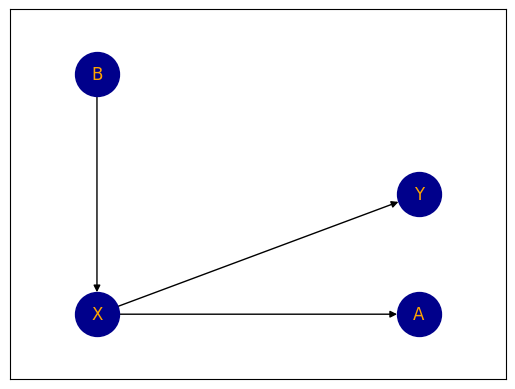

In [3]:
plt.margins(x = 0.2, y = 0.2)

G = nx.DiGraph()

G.add_edges_from([('X', 'Y'), ('X', 'A'), ('B', 'X')])

fixed_positions = {'X': (0, 0), 'Y': (3, 3), 'A': (3, 0), 'B': (0, 6)}

nx.draw_networkx(G, with_labels = True, node_color = 'darkblue', node_size = 1000, font_color = 'orange', pos = fixed_positions)

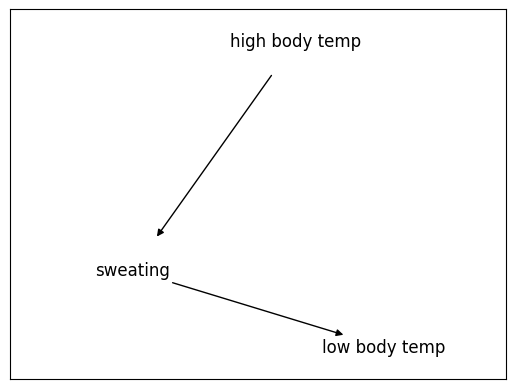

In [6]:
# create a directed graph
# https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('high body temp', 'sweating'),\
                  ('sweating', 'low body temp'),\
                 ])

# fix the positions of all three nodes
fixed_positions = {'high body temp':(1.3,2),\
                   'sweating':(0,0.5), \
                   'low body temp':(2,0)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000, \
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)

In [10]:
# Linear relationship
num = 10000
Z_pesticides = np.maximum(np.random.normal(3, 1, num), 0)
X_deer = np.maximum(np.random.normal(8, 2, num) - Z_pesticides, 0)
Y_flowers = np.maximum(20 - Z_pesticides - X_deer + np.random.normal(0, 1, num), 0)

In [11]:
df = pd.DataFrame({"X_deer": X_deer})

In [13]:
results = sm.OLS(Y_flowers, sm.add_constant(df)).fit()
results.params['X_deer']

np.float64(-0.8036531069443598)

In [185]:
df2 = pd.DataFrame({"X_deer": X_deer, "Z_pesticides": Z_pesticides})

In [186]:
results = sm.OLS(Y_flowers, sm.add_constant(df2)).fit()
results.params

const           20.014780
X_deer          -0.999774
Z_pesticides    -1.005060
dtype: float64

In [18]:
x_coefs = []
n_sims = 5000

for i in range(n_sims):
    # Code to create data for this question 
    num = 100000 
 
    difficulty = np.random.uniform(0, 1, (num,)) 
 
    speed = np.maximum(np.random.normal(15, 5, (num, )) - difficulty * 10, 0) 
 
    accident = np.minimum(np.maximum(0.03 * speed + 0.4 * difficulty + np.random.normal(0, 0.3, (num,)), 0), 1) 
 
    # df = pd.DataFrame({'difficulty': difficulty, 'speed': speed, 'accident': accident}) 
    df = pd.DataFrame({'difficulty': difficulty, 'accident': accident}) 

    results = sm.OLS(speed, sm.add_constant(df)).fit()
    x_coefs.append(results.params["difficulty"])

In [19]:
np.mean(x_coefs)

np.float64(-10.325081509326857)

### Interaction term

In [188]:
num = 10000
Z_pesticides = np.maximum(np.random.normal(3, 1, num), 0)
X_deer = np.maximum(np.random.normal(8, 2, num) - Z_pesticides, 0)
Y_flowers_int = np.maximum(20 - Z_pesticides - X_deer + 0.2 * Z_pesticides * X_deer + np.random.normal(0, 1, num), 0)

In [189]:
df = pd.DataFrame({"X_deer": X_deer, "Z_pesticides": Z_pesticides})
results = sm.OLS(Y_flowers_int, sm.add_constant(df)).fit()
results.params

const           16.883459
X_deer          -0.407819
Z_pesticides    -0.017997
dtype: float64

In [190]:
df_int = pd.DataFrame({"X_deer": X_deer, "Z_pesticides": Z_pesticides, "X_Z": X_deer * Z_pesticides})
results = sm.OLS(Y_flowers_int, sm.add_constant(df_int)).fit()
results.params

const           19.998647
X_deer          -0.997940
Z_pesticides    -0.997319
X_Z              0.198170
dtype: float64

### Nonlinear (Logistic) regression

In [191]:
num = 10000
Z_pesticides = np.maximum(np.random.normal(3, 1, num), 0)
X_deer = np.maximum(np.random.normal(8, 2, num) - Z_pesticides, 0)
true_prob_flowers_lr = 1 / (1 + np.exp(-(4 - 0.5 * Z_pesticides - 0.5 * X_deer)))
Y_flowers_lr = np.random.binomial(1, true_prob_flowers_lr)

In [192]:
#arr = np.arange(10)
#plt.plot(1 / (1 + np.exp(-(1 - arr))))

In [193]:
df_lr = pd.DataFrame({"X_deer": X_deer, "Z_pesticides": Z_pesticides})
results = sm.OLS(Y_flowers_lr, sm.add_constant(df_lr)).fit()
results.params

const           1.364152
X_deer         -0.103429
Z_pesticides   -0.116491
dtype: float64

In [194]:
np.corrcoef(results.predict(sm.add_constant(df_lr)), Y_flowers_lr)

array([[1.       , 0.4094142],
       [0.4094142, 1.       ]])

In [195]:
#plt.plot(results.predict(sm.add_constant(df_lr)), true_prob_flowers_lr, ".")

In [196]:
results = sm.Logit(Y_flowers_lr, sm.add_constant(df_lr)).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.601638
         Iterations 5


const           4.146878
X_deer         -0.495392
Z_pesticides   -0.560897
dtype: float64

In [197]:
probs = results.predict(sm.add_constant(df_lr))
np.corrcoef(probs, Y_flowers_lr)

array([[1.       , 0.4127189],
       [0.4127189, 1.       ]])

In [155]:
#plt.plot(results.predict(sm.add_constant(df_lr)), true_prob_flowers_lr, ".")

In [156]:
for threshold in np.linspace(0.1, 0.9, 9):
    preds = 1 * (probs > threshold)
    print(threshold, accuracy_score(Y_flowers_lr, preds))
print(roc_auc_score(Y_flowers_lr, probs))

0.1 0.5095
0.2 0.5636
0.30000000000000004 0.6195
0.4 0.6609
0.5 0.6764
0.6 0.6635
0.7000000000000001 0.6177
0.8 0.5668
0.9 0.5132
0.7421359751347629


# A backdoor path: we can control for any item in the path

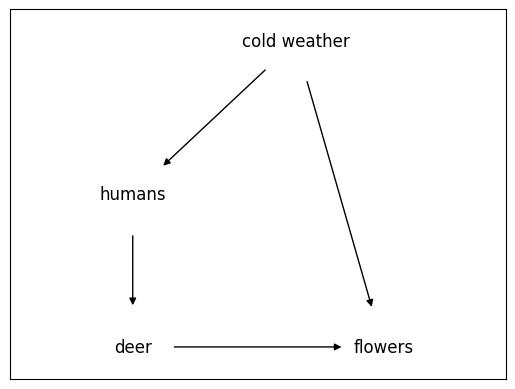

In [5]:
# create a directed graph
# This time, cold weather kills flowers.  Cold weather also chases humans away, which invites deer to return.
# https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('humans', 'deer'),\
                  ('cold weather', 'humans'),\
                  ('cold weather', 'flowers'),\
                  ('deer', 'flowers'),\
                 ])

# fix the positions of all three nodes
fixed_positions = {'cold weather':(1.3,2),\
                   'humans':(0,1),\
                   'deer':(0,0), \
                   'flowers':(2,0)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000,\
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)

In [199]:
num = 10000
W_temp = np.random.normal(50, 10, num)
W_humans = 100 - W_temp + np.random.normal(0, 5, num)
X_deer = 150 - W_humans + np.random.normal(0, 10, num)
Y_flowers = 20 + W_temp - 0.3 * X_deer + np.random.normal(0, 5, num)
df = pd.DataFrame({"W_temp": W_temp, "W_humans": W_humans, "X_deer": X_deer, "Y_flowers": Y_flowers})

In [200]:
df.corr()

,W_temp,W_humans,X_deer,Y_flowers
W_temp,1.000000,-0.896580,0.667701,0.766214
W_humans,-0.896580,1.000000,-0.746056,-0.615427
X_deer,0.667701,-0.746056,1.000000,0.244722
Y_flowers,0.766214,-0.615427,0.244722,1.000000


In [201]:
# Find effect of deer on flowers - no control
results = sm.OLS(Y_flowers, sm.add_constant(df[["X_deer"]])).fit()
results.params

const     24.922320
X_deer     0.151444
dtype: float64

In [202]:
# Find effect of deer on flowers - control for humans 
results = sm.OLS(Y_flowers, sm.add_constant(df[["X_deer", "W_humans"]])).fit()
results.params

const       110.269155
X_deer       -0.299262
W_humans     -0.805793
dtype: float64

In [203]:
# Find effect of deer on flowers - control for temp 
results = sm.OLS(Y_flowers, sm.add_constant(df[["X_deer", "W_temp"]])).fit()
results.params

const     19.593824
X_deer    -0.298022
W_temp     1.004865
dtype: float64

# Two Front Door Paths: not necessary to control for either

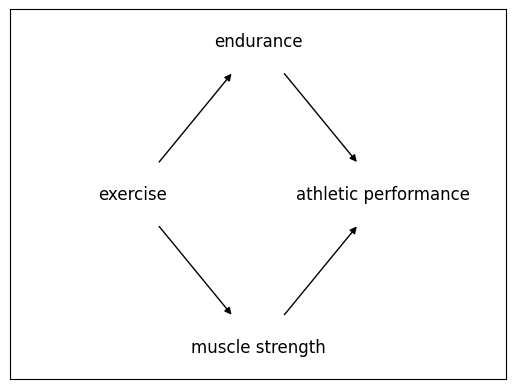

In [226]:
# create a directed graph
# This time, cold weather kills flowers.  Cold weather also chases humans away, which invites deer to return.
# https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('exercise', 'muscle strength'),\
                  ('muscle strength', 'athletic performance'),\
                  ('exercise', 'endurance'),\
                  ('endurance', 'athletic performance'),\
                 ])
                  #('social_media_usage', 'creativity')])

# fix the positions of all three nodes
fixed_positions = {'exercise':(0, 0.5),\
                   'muscle strength':(0.5,0),\
                   'endurance':(0.5,1), \
                   'athletic performance':(1,0.5)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000,\
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)

In [204]:
num = 10000
X_exercise = np.random.normal(10, 2, num)
A_endurance = np.maximum(0.5 * X_exercise + np.random.normal(0, 1, num), 0)
B_muscle = np.maximum(2 * X_exercise + np.random.normal(0, 1, num), 0)
Y_performance = 2 + A_endurance + B_muscle + np.random.normal(0, 1, num)
df = pd.DataFrame({"X_exercise": X_exercise})

In [205]:
results = sm.OLS(Y_performance, sm.add_constant(df)).fit()
results.params

const         1.915253
X_exercise    2.511103
dtype: float64

In [206]:
df_wrong = pd.DataFrame({"X_exercise": X_exercise, "A_endurance": A_endurance, "B_muscle": B_muscle})
results = sm.OLS(Y_performance, sm.add_constant(df_wrong)).fit()
results.params

const          1.932825
X_exercise     0.025629
A_endurance    0.992077
B_muscle       0.993533
dtype: float64

# Collider: we should not control for it

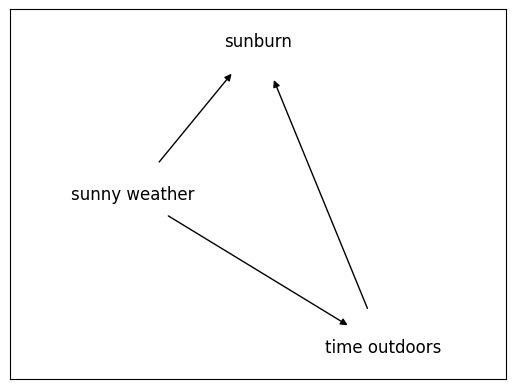

In [236]:
# create a directed graph
# https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('sunny weather', 'sunburn'),\
                  ('time outdoors', 'sunburn'),\
                  ('sunny weather', 'time outdoors'),\
                 ])

# fix the positions of all three nodes
fixed_positions = {'sunny weather':(0,0.5),\
                   'time outdoors':(1,0), \
                   'sunburn':(0.5,1)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000,\
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)

In [97]:
num = 10000
X_sun = 5 + 2 * np.random.normal(0, 1, num)
Y_outdoors = X_sun + 2 * np.random.normal(0, 1, num)
C_sunburn = X_sun + Y_outdoors + np.random.normal(0, 1, num)

df = pd.DataFrame({"X_sun": X_sun, "C_sunburn": C_sunburn}) # We're not supposed to do this
results = sm.OLS(Y_outdoors, sm.add_constant(df)).fit()
results.params

const        0.019454
X_sun       -0.603694
C_sunburn    0.799192
dtype: float64

In [164]:
df = pd.DataFrame({"X_sun": X_sun})
results = sm.OLS(Y_outdoors, sm.add_constant(df)).fit()
results.params

const   -0.000069
X_sun    1.000106
dtype: float64

In [99]:
results.bse

const    0.054655
X_sun    0.010099
dtype: float64